In [1]:
from uproot_io import Events, View
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt

interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
        
particle_id_dict = {-2212:"ANTIPROTON", -321:"KAON -", -211:"PION -", -13:"MUON -", -11:"ELECTRON", 0:"NO BEST MATCH", 11:"POSTIRON", 13:"MUON +", 22:"GAMMA", 211:"PION +", 321:"KAON +", 2212:"PROTON", 3112:"SIGMA -", 3222:"SIGMA +"}

In [2]:
filename="projects\CheatedRecoFile_1.root"
events = Events(filename)

In [3]:
def num_particles_in_event(num_event):
    events.event_number[num_event]
    idx = np.where(events.event_number == num_event)
    print("particles",idx[0][0],"to",idx[0][np.size(idx)-1],"in event",num_event)

In [4]:
num_particles_in_event(9309)

particles 515779 to 516044 in event 9309


In [5]:
particle_id_list = [events.mc_pdg[i] for i in range(516044) if (events.reco_num_hits_w[i] > 15)]
particle_id_list= np.unique(particle_id_list)
print(particle_id_list)
print(particle_id_dict[-2212])

[-2212  -321  -211   -13   -11     0    11    13    22   211   321  2212
  3112  3222]
ANTIPROTON


In [6]:
def plot_event_particle_w(num_particle):
    hits_x_w=np.array([])
    hits_x=np.array([])
    hits_adcs=np.array([])
    for i in range(events.reco_num_hits_w[num_particle]):
        hits_x = np.append(hits_x, events.reco_hits_w[num_particle][i])
        hits_x_w = np.append(hits_x_w, events.reco_hits_x_w[num_particle][i])
        hits_adcs = np.append(hits_adcs, events.reco_adcs_w[num_particle][i])
    hits_bf = np.polyfit(hits_x,hits_x_w,1)
    hits_x_w_fit= [hits_bf[1] + i * hits_bf[0] for i in hits_x]
    #plt.plot([hits_x[0],hits_x[-1]],[hits_x_w_fit[0],hits_x_w_fit[-1]])
    plt.plot(hits_x,hits_x_w_fit)
    plt.scatter(hits_x,hits_x_w,s=8,c=hits_adcs,cmap='hot')
    
        
    
    

In [7]:
def particle_norm_w(num_particle):
    hits_x_w=np.array([])
    hits_x=np.array([])
    for i in range(events.reco_num_hits_w[num_particle]):
        hits_x = np.append(hits_x, events.reco_hits_w[num_particle][i])
        hits_x_w = np.append(hits_x_w, events.reco_hits_x_w[num_particle][i])
    hits_bf = np.polyfit(hits_x,hits_x_w,1)
    hits_x_w_fit= [i * hits_bf[0] + hits_bf[1] for i in hits_x]
    residuals = np.subtract(hits_x_w,hits_x_w_fit)
    rms = np.std(residuals)
    n_variance = np.sum(np.square(residuals))
    n_rms = rms * np.size(hits_x)
    rms_div_nhits = rms/np.size(hits_x)
    rms_div_length=rms/abs(hits_x[0]-hits_x[-1])
    return rms,n_variance,n_rms,rms_div_nhits,rms_div_length
    
    

(0.4050653337020753, 3.6097143404778205, 8.911437341445657, 0.018412060622821604, 0.060403477053770346)
PROTON


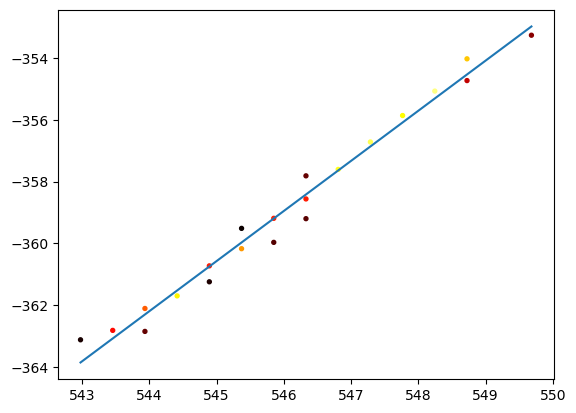

In [8]:

particle = 31

plot_event_particle_w(particle)
print(particle_norm_w(particle))

print(particle_id_dict[events.mc_pdg[particle]])
# rms has some issues compare particle 29 and 31
# rms particle 40


In [28]:
n_particles = 20000
min_hits = 15

def reco_data(metric,filtering): 
    particle_norms = [particle_norm_w(i)[metric] for i in range(n_particles) if (events.reco_num_hits_w[i] > min_hits)]
    particle_id = [events.mc_pdg[i] for i in range(n_particles) if (events.reco_num_hits_w[i] > min_hits)]
    p_data = np.dstack((particle_norms,particle_id))[0]
    #sorting data
    p_data = p_data[p_data[:, 0].argsort()]
    
    # particle filtering
    if filtering == True:
        mean = np.mean(particle_norms)
        std = np.std(particle_norms)
        #print(mean,std)
        sensitivity=[mean+5.0*std,mean+1.8*std,mean+4*std,mean+8*std,mean+8*std]
        for i in range(np.size(particle_norms)):
            if p_data[i][0] > sensitivity[metric]:
                p_data = p_data[:i]
                break
    
    # bins in histogram    
    bins = 10
    bins_array = [(i/bins)*(p_data.max(axis=0)[0]) for i in range(bins+1)]
    k = 0
    for i in range(1,bins+1):
        particle_type = np.array([])
        p_norm = np.array([])
        while p_data[k][0] < bins_array[i]:
            particle_type = np.append(particle_type,p_data[k][1])
            p_norm = np.append(p_norm,p_data[k][0])
            k = k + 1
        if k == np.size(np.concatenate(np.hsplit(p_data,2)[0])) - 1 :
            particle_type = np.append(particle_type,p_data[k][1])
            p_norm = np.append(p_norm,p_data[k][0])
            
        npart = np.size(particle_type)    
        plen = np.size(np.unique(particle_type))
        particle_type = np.unique(particle_type,return_counts=True)
        print("In Bin",i,"there are",npart,"particles which are:")
        for j in range(plen):
            print(particle_type[1][j],particle_id_dict[particle_type[0][j]],end = " ;")
        print("\n")
    
    plt.hist(np.concatenate(np.hsplit(p_data,2)[0]),bins_array)

In Bin 1 there are 1218 particles which are:
2 KAON - ;165 PION - ;15 MUON - ;33 ELECTRON ;193 NO BEST MATCH ;9 POSTIRON ;149 MUON + ;39 GAMMA ;215 PION + ;9 KAON + ;389 PROTON ;

In Bin 2 there are 280 particles which are:
11 PION - ;1 MUON - ;19 ELECTRON ;84 NO BEST MATCH ;5 POSTIRON ;49 MUON + ;102 GAMMA ;8 PION + ;1 KAON + ;

In Bin 3 there are 191 particles which are:
1 KAON - ;1 PION - ;1 MUON - ;13 ELECTRON ;68 NO BEST MATCH ;2 POSTIRON ;14 MUON + ;84 GAMMA ;6 PION + ;1 KAON + ;

In Bin 4 there are 121 particles which are:
1 PION - ;4 ELECTRON ;36 NO BEST MATCH ;2 POSTIRON ;4 MUON + ;71 GAMMA ;3 PION + ;

In Bin 5 there are 56 particles which are:
2 ELECTRON ;20 NO BEST MATCH ;2 MUON + ;31 GAMMA ;1 PION + ;

In Bin 6 there are 20 particles which are:
2 ELECTRON ;9 NO BEST MATCH ;9 GAMMA ;

In Bin 7 there are 17 particles which are:
8 NO BEST MATCH ;7 GAMMA ;2 PION + ;

In Bin 8 there are 16 particles which are:
1 ELECTRON ;6 NO BEST MATCH ;1 POSTIRON ;8 GAMMA ;

In Bin 9 there a

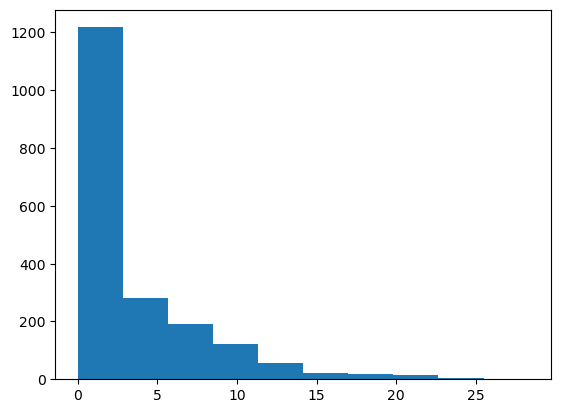

In [29]:
#plot_reco_data(metric,filtering) plots a histogram of the particles with the following metric.
#Filtering = True filters data.
#metric = 0 is rms; metric = 1 is n*variance; metric = 2 is n*rms; metric = 3 is rms/nhits; metric = 4 is rms/length
reco_data(0,True)

In Bin 1 there are 1606 particles which are:
3 KAON - ;178 PION - ;16 MUON - ;71 ELECTRON ;347 NO BEST MATCH ;16 POSTIRON ;146 MUON + ;198 GAMMA ;231 PION + ;11 KAON + ;389 PROTON ;

In Bin 2 there are 113 particles which are:
2 ELECTRON ;33 NO BEST MATCH ;2 POSTIRON ;25 MUON + ;50 GAMMA ;1 PION + ;

In Bin 3 there are 54 particles which are:
1 ELECTRON ;15 NO BEST MATCH ;9 MUON + ;28 GAMMA ;1 PION + ;

In Bin 4 there are 36 particles which are:
8 NO BEST MATCH ;9 MUON + ;19 GAMMA ;

In Bin 5 there are 26 particles which are:
7 NO BEST MATCH ;3 MUON + ;16 GAMMA ;

In Bin 6 there are 16 particles which are:
9 NO BEST MATCH ;1 MUON + ;6 GAMMA ;

In Bin 7 there are 10 particles which are:
1 NO BEST MATCH ;1 POSTIRON ;2 MUON + ;4 GAMMA ;2 PION + ;

In Bin 8 there are 13 particles which are:
2 NO BEST MATCH ;2 MUON + ;9 GAMMA ;

In Bin 9 there are 5 particles which are:
2 MUON + ;3 GAMMA ;

In Bin 10 there are 9 particles which are:
2 NO BEST MATCH ;2 MUON + ;5 GAMMA ;



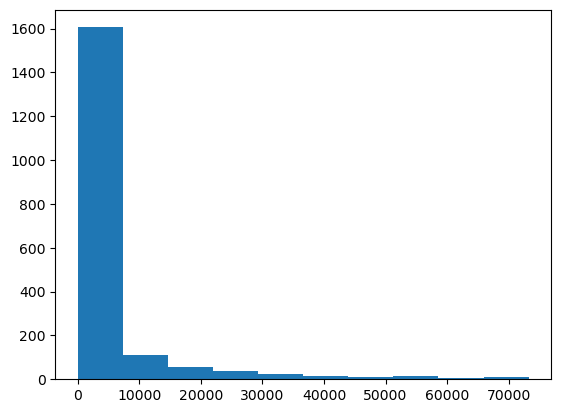

In [30]:
reco_data(1,True)